In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from demo import *

In [4]:
config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        500
POST_NMS_ROIS_TRAININ

In [23]:
from postprocess.visualize import *
def show_instances(image, boxes, masks, class_ids, class_names,
                   scores=None, title="",
                   figsize=(16, 16), ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [num_instances, height, width]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    if not ax:
        figure, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        class_id = class_ids[i]        
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    #figure.savefig(save_path)
    #plt.cla()
    #plt.clf()
    plt.show()
    #plt.close(figure)

In [6]:
pretrained_weight = "./models/mrcnn.pth"
state_dict = torch.load(pretrained_weight)

In [7]:
model = MaskRCNN(config=config, mode='inference')
model.load_state_dict(state_dict)
model.cuda()
model.eval()
cudnn.benchmark = True

In [8]:
image_path = 'README/santas.jpg'
oriImg = cv2.imread(image_path)
image = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)

molded_image, image_metas, windows = mold_inputs([image], config)

In [9]:
inputs = molded_image.transpose((0, 3, 1, 2))
inputs = torch.from_numpy(inputs).float()
inputs = Variable(inputs, volatile=True).cuda()

outputs = model(inputs)

resnet spend 11.38779354095459
fpn spend 1 8.324966669082642
first roalign 0.012152671813964844


In [10]:
rpn_class_logits, rpn_class, rpn_bbox,\
    rpn_rois, mrcnn_class_logits, mrcnn_class,\
    mrcnn_bbox, mrcnn_masks_logits = outputs

mrcnn_class = mrcnn_class.cpu().data.numpy()
mrcnn_bbox = mrcnn_bbox.cpu().data.numpy()

In [11]:
rois = rpn_rois.cpu().data.numpy() / 1024.
rois = rois[:, :, [1, 0, 3, 2]]

detections = final_detections(
    rois, mrcnn_class, mrcnn_bbox, image_metas, config)

mask_rois = detections[..., :4][..., [1, 0, 3, 2]]
mask_rois = to_variable(mask_rois, volatile=True).cuda()

In [12]:
mrcnn_mask = model.rpn_mask(model.mrcnn_feature_maps, mask_rois)

In [17]:
mrcnn_mask_prob = F.sigmoid(mrcnn_mask)
mrcnn_mask_npy = mrcnn_mask_prob.cpu().data.numpy()
mrcnn_mask_npy = mrcnn_mask_npy.transpose(0, 1, 3, 4, 2)

final_rois, final_class_ids, final_scores, final_masks =\
unmold_detections(detections[0], mrcnn_mask_npy[0],
                  oriImg.shape, windows[0])
    
result = {
    "rois": final_rois,
    "class_ids": final_class_ids,
    "scores": final_scores,
    "masks": final_masks,
}

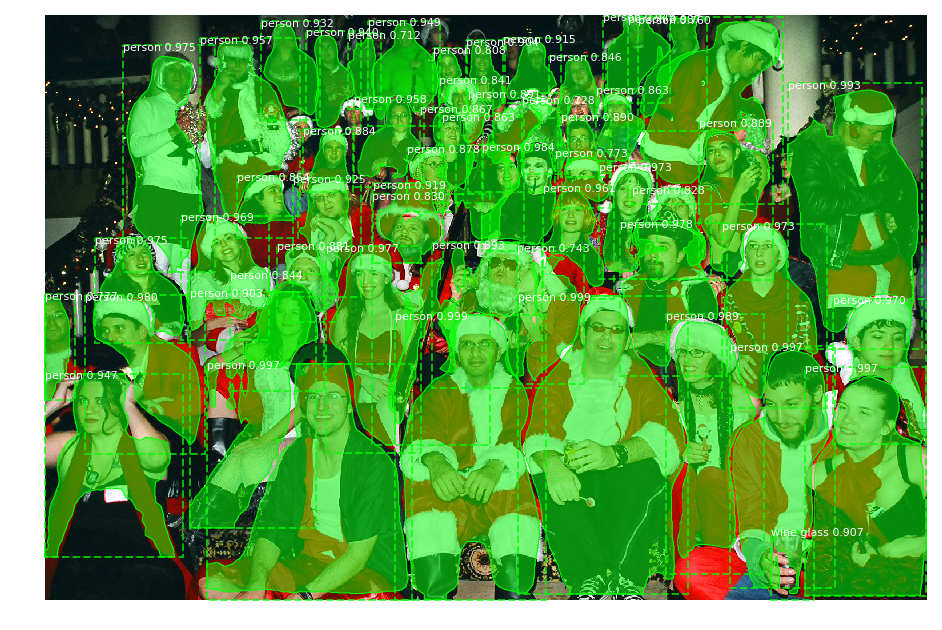

In [24]:
show_instances(image, result['rois'], result['masks'], result['class_ids'],
                            class_names, result['scores'])